In [3]:
import os
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quilt
from quilt.data.elijahc import ripc

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [5]:
# Load sample and subject tables
samples = ripc.meta.samples()
subjects = ripc.meta.subjects()

df = ripc.untargeted.log2fc_plasma()
abs_df = ripc.targeted.abs_quant()
pop_df = ripc.untargeted.log2fc_plasma_agg_stats()

In [6]:
df.head()

,Molecular_Weight,10A,10B,10C,10D,10E,10F,10G,10H,10I,...,9B,9C,9D,9E,9F,9G,9H,9I,9J,4J
0,65.01201,0.0,-0.333174,-0.310196,-0.211132,-0.087471,-0.257130,-0.334422,-0.267074,-0.280800,...,0.149465,-0.018649,0.132525,0.145457,0.164234,0.023408,0.232332,0.101342,0.055404,-0.226212
1,65.01261,0.0,0.002091,-0.674182,-0.181348,0.434307,0.304864,0.125699,-1.154838,-0.149845,...,-0.301424,-0.611503,-0.374957,-0.041667,-0.287942,-0.176074,-0.211045,-0.240499,-1.324743,-0.368653
2,65.01296,0.0,0.101683,-0.750955,-0.047181,0.561751,0.449384,0.231678,0.716774,-0.037846,...,-0.052453,0.139522,-0.206524,-0.011095,0.144977,-0.272530,0.120714,-0.017269,-0.307084,-0.571821
3,65.98965,0.0,0.389915,0.139742,0.389478,1.551224,0.101034,0.323112,0.707647,0.352318,...,-0.523150,-0.974390,-1.162224,-1.326142,-1.354063,-1.299357,-1.459755,-0.925218,0.018010,0.377716
4,65.99026,0.0,-0.144912,0.128382,-0.167470,0.205957,0.041491,0.132742,0.111044,0.227684,...,0.204331,-0.433068,-0.029319,0.088639,0.432058,0.166155,0.109727,0.510042,-0.891744,0.820730


In [ ]:
metabolites = list(abs_df.columns[12:])
platelets_df = abs_df[abs_df['Sample type']=='Platelets'].copy()
plasma_df = abs_df[abs_df['Sample type']=='Plasma']
plasma_df['min']=list(map(lambda sid: timestamps[sid[-1]],plasma_df['Sample ID'].values))
plasma_long_df = pd.melt(plasma_df,id_vars=['Subject','Sex','min','Sample ID','Sample type'],value_vars=metabolites,var_name='Metabolite')
pt_demographics_cols = ['Sample ID','Subject','Sample type','Sex','Height (m)','Weight (kg)','Systolic Blood Pressure','Diastolic Blood Pressure',]
demog_df = abs_df[pt_demographics_cols]

In [541]:
func = np.log2
in_df = plasma_df
cols = list(in_df.columns)
eps = np.finfo(float).eps
baseline_rgx = re.compile(r"(\d+A)")
t_rgx = lambda l: re.compile(r"(\d+{}).?".format(l))
baseline_idxs = in_df['Sample ID'].isin(list(filter(baseline_rgx.search,in_df['Sample ID']))[:30])
baseline = in_df[baseline_idxs][metabolites].values
print('baseline shape:',baseline.shape)
timestamps = {'A':0,'B':2,'C':4,'D':6,'E':8,'F':10,'G':20,'H':30,'I':45,'J':60}
letters = ['A','B','C','D','E']
t_cols = [ list(set(filter(t_rgx(l).search,in_df['Sample ID']))) for l in timestamps.keys() ]
final = [ in_df[in_df['Sample ID'].isin(tc)][['Sample ID','Subject','min']+metabolites] for tc in t_cols ]
# norm_mat = [ func((f[metabolites].values+0.01)/(baseline)) for f in final ]
# norm_mat = [ ((f[metabolites].values-baseline)/(baseline)) for f in final ]
norm_mat = [ func((f[metabolites].values+1)/(baseline+1)) for f in final ]
norm_df = []
for m,f in zip(norm_mat,final):
    df = pd.DataFrame(m,columns=metabolites)
#     df['Sample ID']=f['Sample ID'].values
    df['Subject']=f['Subject'].values
    df['min']=f['min'].values
    df['sample_id']=f['Sample ID'].values
    norm_df.append(df)

out_df = norm_df[0]
for df in norm_df[1:]:
    out_df = out_df.append(df)
out_df = out_df.reset_index().drop(columns=['index'])

baseline shape: (30, 33)


In [542]:
out_df.to_csv('../data/abs_fc.csv')

In [561]:
sex_df = demog_df[['Subject','Sex']].drop_duplicates()
sex_df.Sex = sex_df.Sex.astype(str)
sex_df.head()

,Subject,Sex
0,1,Female
12,2,Male
24,3,Male
36,4,Male
48,5,Male


In [610]:
abs_fc_df = pd.melt(out_df,id_vars=['sample_id','Subject','min'],value_vars=metabolites,var_name='Name',value_name='log2_fc')
abs_fc_df = abs_fc_df.join(sex_df.set_index('Subject'),on='Subject',)
abs_fc_df.to_pickle('../data/abs_fc.pk')

In [539]:
epoch_stats = abs_fc_df.groupby('min').agg(['mean','var'])['log2_fc'].reset_index()
abs_pop_stats = abs_fc_df.groupby(['min','Name']).agg(['mean','var'])['log2_fc'].reset_index()

In [540]:
epoch_stats

,min,mean,var
0,0,0.000000,0.000000
1,2,0.009941,0.527702
2,4,0.016742,0.434640
3,6,0.019700,0.259908
4,8,0.015347,0.287763
5,10,0.030211,0.375297
6,20,-0.052354,0.812930
7,30,-0.017155,0.482544
8,45,-0.078182,0.612481
9,60,-0.042107,0.297240


In [441]:
from tqdm import tqdm as tqdm
import scipy.stats as stats
t_stats = []
p_stats = []
for index,row in tqdm(abs_pop_stats.iterrows(),total=330):
    _,_,pop_mean,pop_var = epoch_stats.query("min == {}".format(row['min'])).to_records()[0]
    if row['min']==0:
        t,p = stats.ttest_ind_from_stats(pop_mean,np.sqrt(0.001),32*30,row['mean'],np.sqrt(row['var']),30,equal_var=False)
    else:
        t,p = stats.ttest_ind_from_stats(pop_mean,np.sqrt(pop_var),32*30,row['mean'],np.sqrt(row['var']),30,equal_var=False)
        
    t_stats.append(t)
    p_stats.append(p)

100%|██████████| 330/330 [00:00<00:00, 375.17it/s]


In [451]:
abs_pop_stats['p-value']=p_stats
volc_df = abs_pop_stats
volc_df['log10p-value']=-np.log10(abs_pop_stats['p-value'].values)
volc_df.columns = ['min','Name','log2fc_mean','log2fc_var','p-value','log10p-value']
volc_df.tail()

,min,Name,log2fc_mean,log2fc_var,p-value,log10p-value
325,60,Pyruvate,0.004083,0.313078,0.659015,0.181105
326,60,Sphingosine 1-phosphate,0.016414,0.021749,0.073948,1.131072
327,60,Succinate,-0.087603,0.119092,0.491529,0.308451
328,60,Tryptophan,-0.063823,0.076142,0.686427,0.163406
329,60,Urate,-0.045957,0.777229,0.981189,0.008247


In [584]:
names = volc_df.Name.drop_duplicates().astype(str).values.tolist()

['2-Oxoglutarate',
 '4-Hydroxy-2-quinolinecarboxylic acid',
 'Adenosine',
 'Alanine',
 'Aspartate',
 'Citrate',
 'D-Glucose',
 'Fumarate',
 'Glutathione',
 'Glycine',
 'Hexadecanoic acid',
 'Hypoxanthine',
 'Kynurenine',
 'L-Arginine',
 'L-Cystine',
 'L-Glutamate',
 'L-Histidine',
 'L-Isoleucine/L-Leucine',
 'L-Lysine',
 'L-Methionine',
 'L-Phenylalanine',
 'L-Proline',
 'L-Serine',
 'L-Threonine',
 'L-Tyrosine',
 'L-Valine',
 'Lactate',
 'N-N-Dimethylglycine',
 'Pyruvate',
 'Sphingosine 1-phosphate',
 'Succinate',
 'Tryptophan',
 'Urate']

In [ ]:
df_filt = lambda df,field,val: df[df[field]==val]

In [452]:
abs_pop_stats.to_pickle('../data/abs_fc_stats.pk')

In [527]:
# name_df = df[['Molecular_Weight','min','Name']].drop_duplicates('Molecular_Weight')
# volc_df = pop_df.merge(name_df,how='left',on=['min','Molecular_Weight'])
# print(len(volc_df))
# volc_df['log10p-value'] = -np.log10(volc_df['p-value'].values)
# volc_df.tail()

In [524]:
xrange = (-3,3)
yrange = (0,8)
TOOLS = 'pan,wheel_zoom,reset,hover,save'
timepoint = 10

In [1]:
from bokeh.transform import linear_cmap, log_cmap,factor_cmap
from bokeh.palettes import Spectral6, Plasma,cividis
def volcano_plot(volc_df,timepoint=2,xrange=(-4,4),yrange=(0,8),tools='pan,wheel_zoom,reset,hover,save',output_path=None):
    source = ColumnDataSource(volc_df.query('min == '+str(timepoint)))
    names = volc_df.Name.drop_duplicates().astype(str).values.tolist()

#     mapper = log_cmap(field_name='Molecular_Weight', palette=Plasma256 ,low=min(volc_df['Molecular_Weight'].values) ,high=max(volc_df['Molecular_Weight'].values))
    fill_color=factor_cmap('Name', palette=cividis(33), factors=names)
    p = bp.figure(tools=tools, x_range=xrange, y_range=yrange)
    p.hover.tooltips = [
        ("Name","@Name"),
#         ("Molecular Weight", "@{Molecular_Weight}"),
        ("Log2 Fold Change", "@log2fc_mean"),
        ('p-value', '@{p-value}')
    ]
    
    p.circle("log2fc_mean","log10p-value", fill_color=fill_color,size=5,source=source)
    
    p.title.text = "Population Volcano plot @ {}min".format(timepoint)
    p.yaxis.axis_label = '-log10(p-value)'
    p.xaxis.axis_label = 'log2(FoldChange)'


    sig_stat_line = Span(location=-np.log10(0.05),
                            dimension='width', line_color='black',
                            line_dash='dashed', line_width=1)
    
    sig_stat_line3 = Span(location=-np.log10(0.001),
                            dimension='width', line_color='black',
                            line_dash='dashed', line_width=1)
    
    p.add_layout(sig_stat_line)
    p.add_layout(sig_stat_line3)

    zero_change = Span(location=0,
                            dimension='height', line_color='black',
                            line_dash='dashed', line_width=1)
    p.add_layout(zero_change)
    
    if output_path is not None:
        bp.output_file(os.path.join(output_path,"volcano{}.html".format(timepoint)), title="Log2 Fold Change @ {}min".format(timepoint))

    return p

In [2]:
bp.output_notebook()
p = volcano_plot(volc_df,timepoint=10,xrange=(-0.5,0.5),yrange=(0,3))
bp.show(p)

NameError: name 'bp' is not defined

# Make volcano plots for all timepoints

In [10]:
# for tp in [2,6,10]:
#     p = volcano_plot(volc_df,timepoint=tp,output_path="../viz/bokeh")
#     bp.show(p)
# p = volcano_plot(volc_df,output_path="../viz/bokeh")


In [21]:
df['Molecular_Weight_short'] = np.round(df['Molecular_Weight'].values,decimals=3)
df.query('Molecular_Weight_short == 468.349').head()

,Name,Molecular_Weight,sample_id,log2_fc,patient_id,min,Molecular_Weight_short
35868,nan,468.34854,1A,0.0,1,0,468.349
109683,nan,468.34854,2A,0.0,2,0,468.349
183498,nan,468.34854,3A,0.0,3,0,468.349
257313,nan,468.34854,4A,0.0,4,0,468.349
331128,nan,468.34854,5A,0.0,5,0,468.349


/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


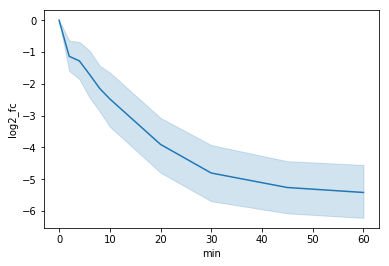

In [20]:
compound_w = 468.349
sns.lineplot(x='min',y='log2_fc',data=df.query('Molecular_Weight_short == 468.349'))

In [10]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage

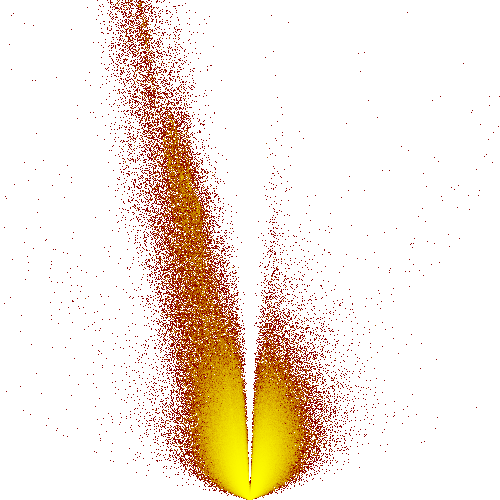

In [22]:
canvas = ds.Canvas(plot_width=500,plot_height=500, x_range=xrange,y_range=yrange)
agg = canvas.points(volc_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')

In [ ]:
bp.output_notebook()
TOOLS = 'pan,wheel_zoom,reset,tap'
# source = ColumnDataSource(df.query("min == 6"))
p = bp.figure(tools=TOOLS, x_range=xrange, y_range=yrange)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(pop_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
    img = tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p,image_callback)